# XGBoost Model Training with Ablation Study
## GoBest Cab - Dangerous Driving Behaviour Detection

This notebook implements XGBoost classifier for detecting dangerous driving behaviour with:
- MLflow experiment tracking
- Class imbalance handling
- Regularization techniques to prevent overfitting
- Comprehensive ablation study

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from xgboost import XGBClassifier

# MLflow
import mlflow
import mlflow.xgboost
from mlflow.models.signature import infer_signature

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. MLflow Setup

In [2]:
# MLflow Configuration
# Set tracking URI to the MLflow server
mlflow.set_tracking_uri("http://localhost:5000")

# Define experiment naming convention: {model_name}_{dataset}_{reg/noreg}
EXPERIMENT_BASE_NAME = "XGBoost_balanced_smote"

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Tracking URI: http://localhost:5000


## 2. Load Data

In [3]:
# Load the main dataset
DATA_PATH = "../../Datasets/ca2_balanced_smote/balanced_smote.csv"
CLASS_WEIGHTS_PATH = "../../Datasets/ca2_balanced_smote/class_weights.json"

df = pd.read_csv(DATA_PATH)

# Load class weights from JSON
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    class_weights_info = json.load(f)

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nClass weights info:")
print(json.dumps(class_weights_info, indent=2))

Dataset shape: (29988, 144)

Class distribution:
label
0    14994
1    14994
Name: count, dtype: int64

Class weights info:
{
  "class_0_weight": 0.665999733226624,
  "class_1_weight": 2.0060265166733626,
  "scale_pos_weight": 3.0120530333467253,
  "original_class_0": 14994,
  "original_class_1": 4978,
  "imbalance_ratio": 3.0120530333467257
}


In [4]:
# Prepare features and target
# IMPORTANT: Exclude bookingID and is_dangerous_trip - they are just references
columns_to_drop = ['bookingID', 'label']

# Check if is_dangerous_trip exists and drop it
if 'is_dangerous_trip' in df.columns:
    columns_to_drop.append('is_dangerous_trip')

# Also drop is_synthetic if it exists (it's a SMOTE indicator, not a feature)
if 'is_synthetic' in df.columns:
    columns_to_drop.append('is_synthetic')

X = df.drop(columns=columns_to_drop)
y = df['label']

# Save feature column order for GUI inference
import os
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

feature_cols = X.columns.tolist()

with open(os.path.join(models_dir, "xgboost_feature_cols.json"), "w") as f:
    json.dump(feature_cols, f, indent=2)

print("Saved feature columns:", len(feature_cols))

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist()[:10], "... and", len(X.columns)-10, "more")

Saved feature columns: 141
Features shape: (29988, 141)
Target shape: (29988,)

Feature columns (141):
['vehicle_key', 'trip_duration_sec', 'total_distance_km', 'avg_gps_accuracy', 'harsh_acceleration_count', 'harsh_braking_count', 'sharp_turn_count', 'speeding_event_count', 'phone_distraction_count', 'avg_acceleration_magnitude'] ... and 131 more


## 3. Data Preprocessing

In [5]:
# Check for missing values and handle them
print("Missing values per column:")
missing = X.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill missing values with median (robust to outliers)
    X = X.fillna(X.median())
    print("\nMissing values filled with median.")
else:
    print("No missing values found.")

# Check for infinite values
inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
print(f"\nInfinite values count: {inf_count}")
if inf_count > 0:
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("Infinite values replaced with median.")

Missing values per column:
No missing values found.

Infinite values count: 0


In [6]:
# Train-test split with stratification to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Training set: 23990 samples
Test set: 5998 samples

Training class distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Test class distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [7]:
# Feature scaling using RobustScaler (less sensitive to outliers)
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

print("Feature scaling completed using RobustScaler.")

Feature scaling completed using RobustScaler.


## 4. Class Imbalance Handling

In [8]:
# Set up class weights for handling imbalance
# Using scale_pos_weight from the class_weights.json
scale_pos_weight = class_weights_info.get('scale_pos_weight', 3.0)

# Alternative: manual class weight dictionary
class_weight_dict = {
    0: class_weights_info.get('class_0_weight', 1.0),
    1: class_weights_info.get('class_1_weight', 3.0)
}

print(f"Scale pos weight: {scale_pos_weight}")
print(f"Class weight dictionary: {class_weight_dict}")

Scale pos weight: 3.0120530333467253
Class weight dictionary: {0: 0.665999733226624, 1: 2.0060265166733626}


## 5. Helper Functions

In [9]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with all required metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba),
    }
    
    # Detect overfitting
    overfit_gap = metrics['train_f1'] - metrics['test_f1']
    metrics['overfit_gap'] = overfit_gap
    metrics['is_overfitting'] = overfit_gap > 0.05  # 5% gap threshold
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"\nAccuracy  - Train: {metrics['train_accuracy']:.4f} | Test: {metrics['test_accuracy']:.4f}")
    print(f"F1 Score  - Train: {metrics['train_f1']:.4f} | Test: {metrics['test_f1']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"\nOverfit Gap (Train F1 - Test F1): {overfit_gap:.4f}")
    if metrics['is_overfitting']:
        print("⚠️  WARNING: Model shows signs of overfitting!")
    else:
        print("✅ Model generalization looks good.")
    
    return metrics, y_test_pred, y_test_proba


def plot_confusion_matrix(y_test, y_pred, model_name="Model"):
    """
    Plot confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe (0)', 'Dangerous (1)'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    return fig


def plot_roc_curve(y_test, y_proba, model_name="Model"):
    """
    Plot ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - ROC Curve')
    ax.legend(loc='lower right')
    plt.tight_layout()
    return fig


def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """
    Plot top N feature importances.
    """
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1][:top_n]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(top_n), importance[indices][::-1], align='center')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels([feature_names[i] for i in indices][::-1])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'{model_name} - Top {top_n} Feature Importances')
    plt.tight_layout()
    return fig


def plot_learning_history(evals_result, model_name="Model"):
    """
    Plot XGBoost learning history (training vs validation loss).
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    epochs = len(evals_result['train']['logloss'])
    x_axis = range(1, epochs + 1)
    
    ax.plot(x_axis, evals_result['train']['logloss'], 'b-', label='Train Loss', linewidth=2)
    ax.plot(x_axis, evals_result['validation']['logloss'], 'r-', label='Validation Loss', linewidth=2)
    
    ax.set_xlabel('Boosting Iterations')
    ax.set_ylabel('Log Loss')
    ax.set_title(f'{model_name} - Learning History')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

## 6. Cross-Validation Setup

In [10]:
# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def perform_cross_validation(model, X, y, cv=cv):
    """
    Perform cross-validation and return scores.
    """
    scoring = ['f1', 'precision', 'recall', 'roc_auc', 'accuracy']
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    
    print("\nCross-Validation Results (5-fold):")
    print("-" * 50)
    for metric in scoring:
        train_scores = cv_results[f'train_{metric}']
        test_scores = cv_results[f'test_{metric}']
        print(f"{metric.upper():12} - Train: {train_scores.mean():.4f} (+/- {train_scores.std()*2:.4f}) | "
              f"Test: {test_scores.mean():.4f} (+/- {test_scores.std()*2:.4f})")
    
    return cv_results

---
## 7. Model Training WITHOUT Regularization
### Baseline XGBoost Model (High Complexity, No Regularization)

In [11]:
# Set experiment for no regularization
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_noreg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_noreg")

Experiment: XGBoost_balanced_smote_noreg


In [12]:
# XGBoost WITHOUT Regularization (baseline - likely to overfit)
xgb_noreg = XGBClassifier(
    n_estimators=100,  # Reduced for faster training
    max_depth=10,  # Deep trees - prone to overfitting
    learning_rate=0.1,
    min_child_weight=1,  # Low value - prone to overfitting
    gamma=0,  # No regularization
    subsample=1.0,  # Use all samples - prone to overfitting
    colsample_bytree=1.0,  # Use all features - prone to overfitting
    reg_alpha=0,  # No L1 regularization
    reg_lambda=1,  # Minimal L2 regularization (XGBoost default)
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("XGBoost Model (No Regularization) Configuration:")
print(xgb_noreg.get_params())

XGBoost Model (No Regularization) Configuration:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': 3.0120530333467253, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Training XGBoost without regularization...

XGBoost (No Regularization) Evaluation Results

Accuracy  - Train: 0.9985 | Test: 0.8314
F1 Score  - Train: 0.9985 | Test: 0.8392
Precision: 0.8023
Recall:    0.8796
ROC-AUC:   0.9325

Overfit Gap (Train F1 - Test F1): 0.1594
⚠️  WARNING: Model shows signs of overfitting!


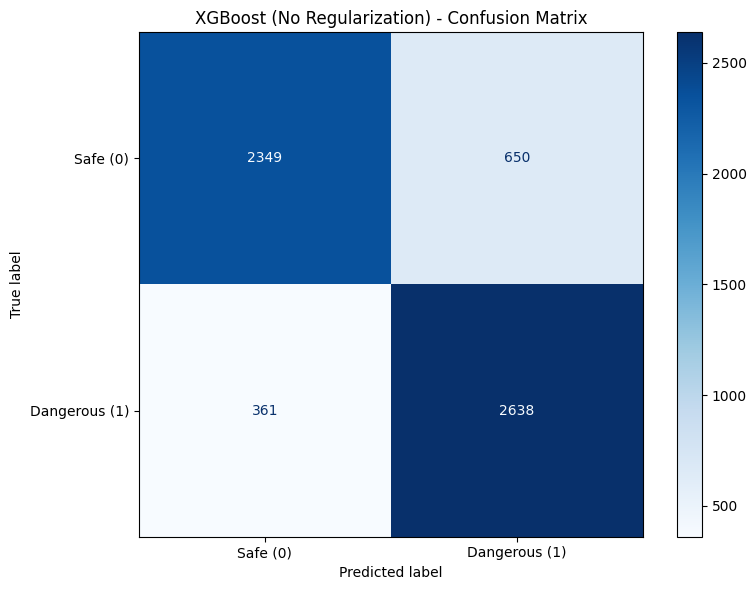

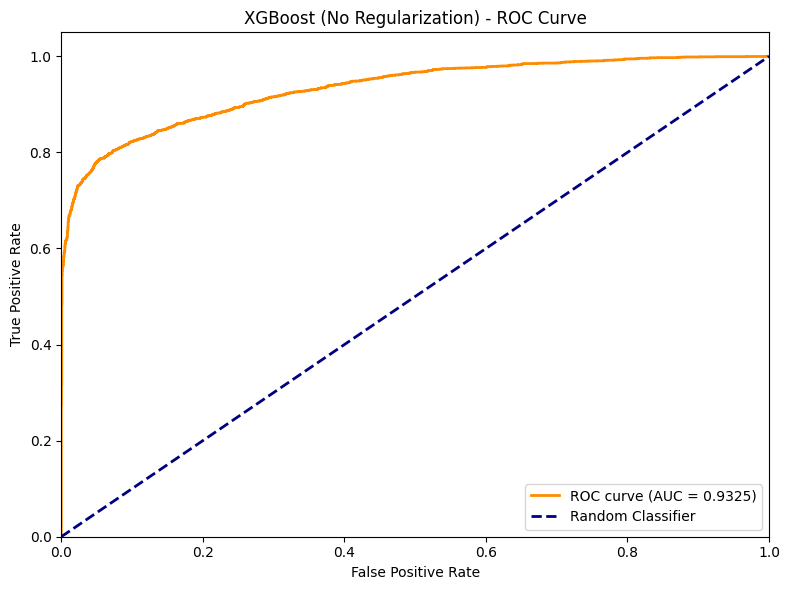

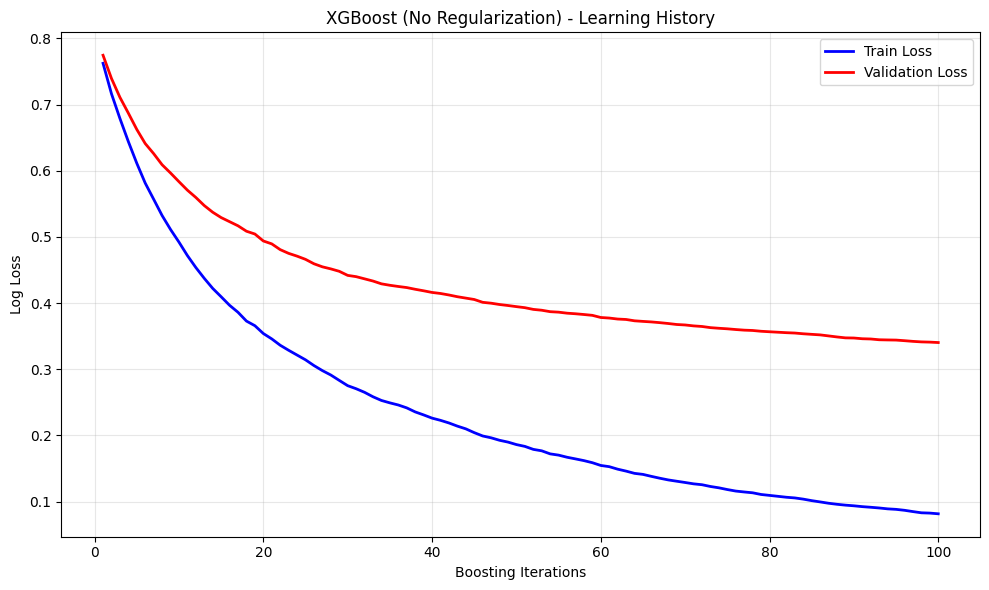

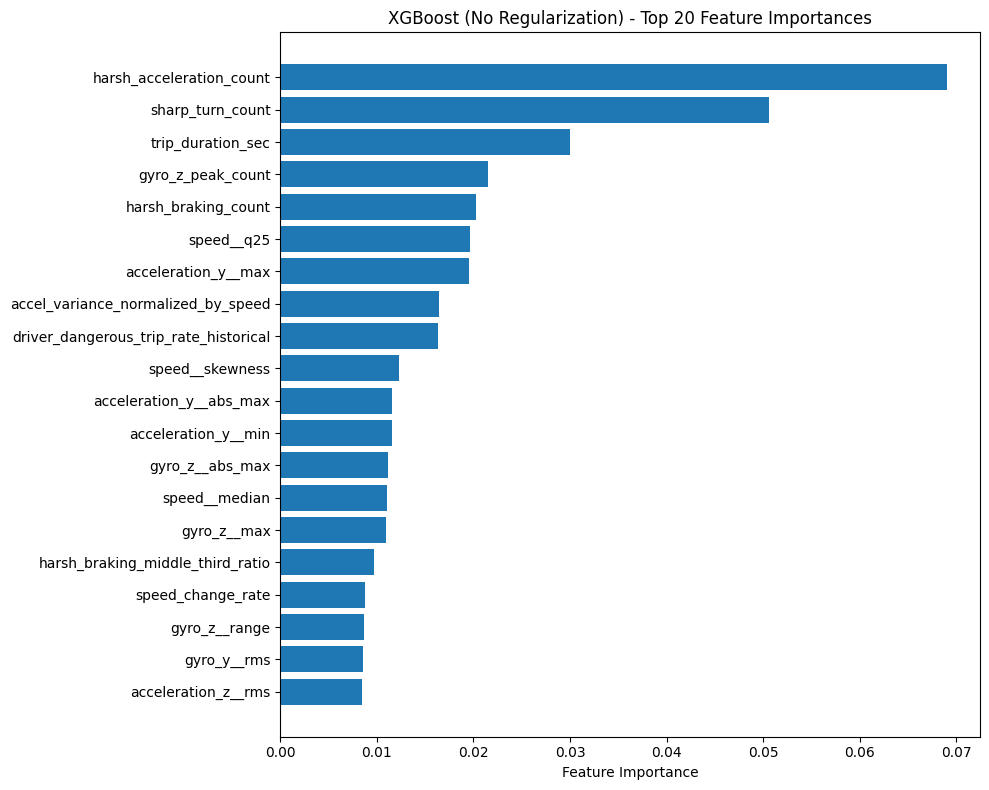

2026/01/31 18:06:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: 8ca566e93d804b2e90593baf6fac832a
🏃 View run XGBoost_NoReg_Baseline at: http://localhost:5000/#/experiments/11/runs/8ca566e93d804b2e90593baf6fac832a
🧪 View experiment at: http://localhost:5000/#/experiments/11


In [13]:
# Train the model without regularization
with mlflow.start_run(run_name="XGBoost_NoReg_Baseline"):
    # Log parameters
    mlflow.log_params(xgb_noreg.get_params())
    mlflow.log_param("regularization", "none")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model with eval_set for learning history
    print("Training XGBoost without regularization...")
    eval_set_noreg = [(X_train_scaled, y_train, 'train'), (X_test_scaled, y_test, 'validation')]
    xgb_noreg.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], verbose=False)
    evals_result_noreg = xgb_noreg.evals_result()
    
    # Evaluate
    metrics_noreg, y_pred_noreg, y_proba_noreg = evaluate_model(
        xgb_noreg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="XGBoost (No Regularization)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_noreg['train_accuracy'],
        'test_accuracy': metrics_noreg['test_accuracy'],
        'train_f1': metrics_noreg['train_f1'],
        'test_f1': metrics_noreg['test_f1'],
        'precision': metrics_noreg['precision'],
        'recall': metrics_noreg['recall'],
        'roc_auc': metrics_noreg['roc_auc'],
        'overfit_gap': metrics_noreg['overfit_gap']
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_noreg, "XGBoost (No Regularization)")
    mlflow.log_figure(fig_cm, "confusion_matrix_noreg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_noreg, "XGBoost (No Regularization)")
    mlflow.log_figure(fig_roc, "roc_curve_noreg.png")
    plt.show()
    
    # Plot and log learning history
    fig_lh = plot_learning_history({'train': evals_result_noreg['validation_0'], 'validation': evals_result_noreg['validation_1']}, "XGBoost (No Regularization)")
    mlflow.log_figure(fig_lh, "learning_history_noreg.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(xgb_noreg, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="XGBoost (No Regularization)")
    mlflow.log_figure(fig_fi, "feature_importance_noreg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.xgboost.log_model(xgb_noreg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [14]:
# Cross-validation for no-reg model
print("\n" + "="*60)
print("Cross-Validation for XGBoost (No Regularization)")
print("="*60)
cv_results_noreg = perform_cross_validation(xgb_noreg, X_train_scaled, y_train)


Cross-Validation for XGBoost (No Regularization)

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 0.9994 (+/- 0.0003) | Test: 0.8362 (+/- 0.0127)
PRECISION    - Train: 0.9988 (+/- 0.0006) | Test: 0.8026 (+/- 0.0246)
RECALL       - Train: 1.0000 (+/- 0.0000) | Test: 0.8728 (+/- 0.0087)
ROC_AUC      - Train: 1.0000 (+/- 0.0000) | Test: 0.9248 (+/- 0.0072)
ACCURACY     - Train: 0.9994 (+/- 0.0003) | Test: 0.8289 (+/- 0.0159)


In [15]:
# Classification Report
print("\nClassification Report (No Regularization):")
print(classification_report(y_test, y_pred_noreg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (No Regularization):
               precision    recall  f1-score   support

     Safe (0)       0.87      0.78      0.82      2999
Dangerous (1)       0.80      0.88      0.84      2999

     accuracy                           0.83      5998
    macro avg       0.83      0.83      0.83      5998
 weighted avg       0.83      0.83      0.83      5998



---
## 8. Model Training WITH Regularization
### XGBoost with Regularization to Combat Overfitting

In [16]:
# Set experiment for regularized model
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_reg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_reg")

Experiment: XGBoost_balanced_smote_reg


In [17]:
# XGBoost WITH Regularization
xgb_reg = XGBClassifier(
    n_estimators=300,
    max_depth=6,  # Reduced depth to prevent overfitting
    learning_rate=0.05,  # Lower learning rate for better generalization
    min_child_weight=5,  # Higher value to require more samples per leaf
    gamma=0.1,  # Minimum loss reduction for split
    subsample=0.8,  # Use 80% of samples per tree
    colsample_bytree=0.8,  # Use 80% of features per tree
    colsample_bylevel=0.8,  # Feature sampling at each level
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("XGBoost Model (With Regularization) Configuration:")
print("\nRegularization techniques applied:")
print("- Reduced max_depth: 10 -> 6")
print("- Lower learning_rate: 0.1 -> 0.05")
print("- Increased min_child_weight: 1 -> 5")
print("- Added gamma: 0 -> 0.1")
print("- Subsampling: 1.0 -> 0.8")
print("- Column sampling: 1.0 -> 0.8")
print("- L1 regularization (reg_alpha): 0 -> 0.1")
print("- L2 regularization (reg_lambda): 1 -> 1.0")

XGBoost Model (With Regularization) Configuration:

Regularization techniques applied:
- Reduced max_depth: 10 -> 6
- Lower learning_rate: 0.1 -> 0.05
- Increased min_child_weight: 1 -> 5
- Added gamma: 0 -> 0.1
- Subsampling: 1.0 -> 0.8
- Column sampling: 1.0 -> 0.8
- L1 regularization (reg_alpha): 0 -> 0.1
- L2 regularization (reg_lambda): 1 -> 1.0


Training XGBoost with regularization...

XGBoost (Regularized) Evaluation Results

Accuracy  - Train: 0.8953 | Test: 0.7798
F1 Score  - Train: 0.9046 | Test: 0.8058
Precision: 0.7206
Recall:    0.9140
ROC-AUC:   0.9168

Overfit Gap (Train F1 - Test F1): 0.0988
⚠️  WARNING: Model shows signs of overfitting!


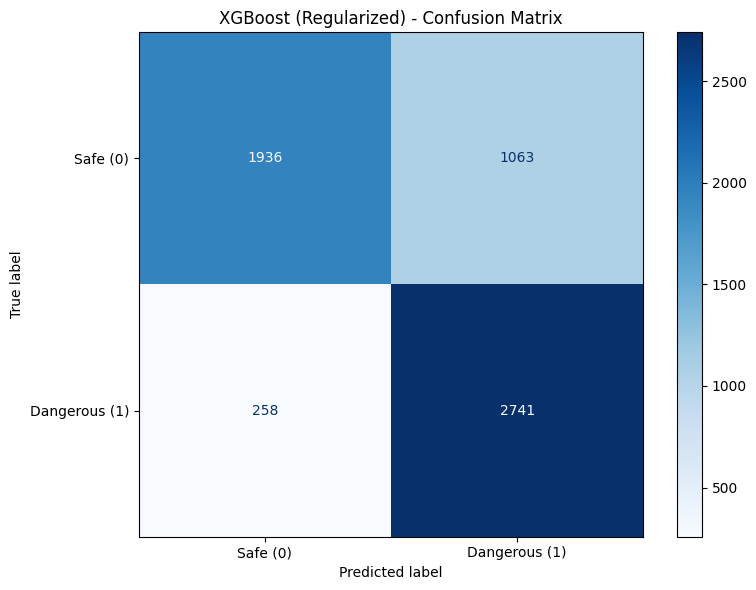

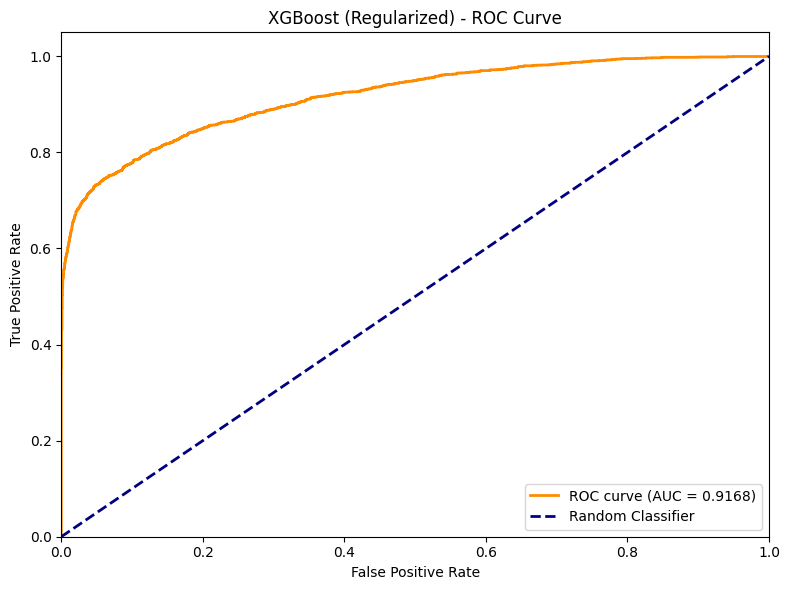

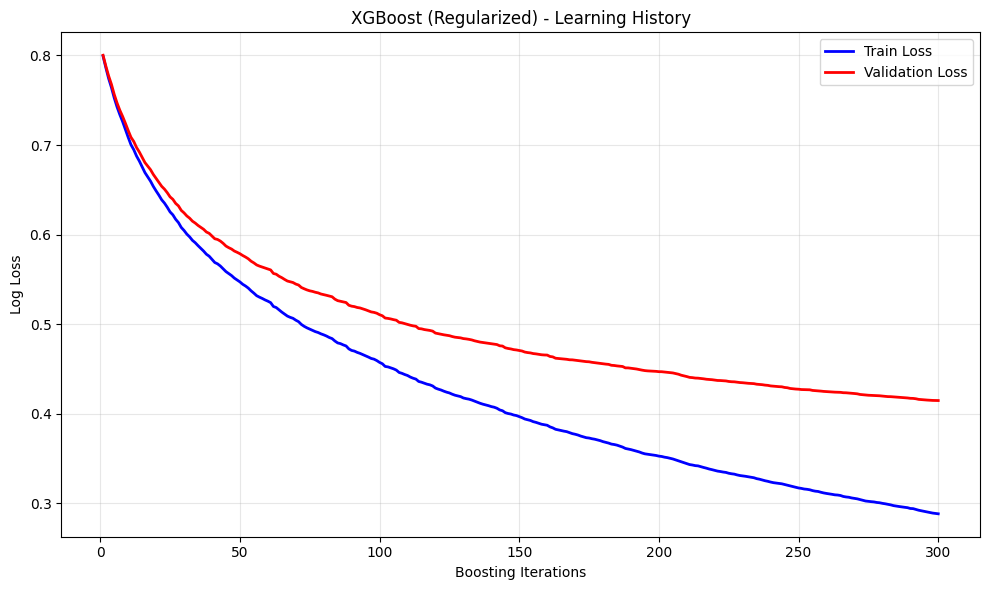

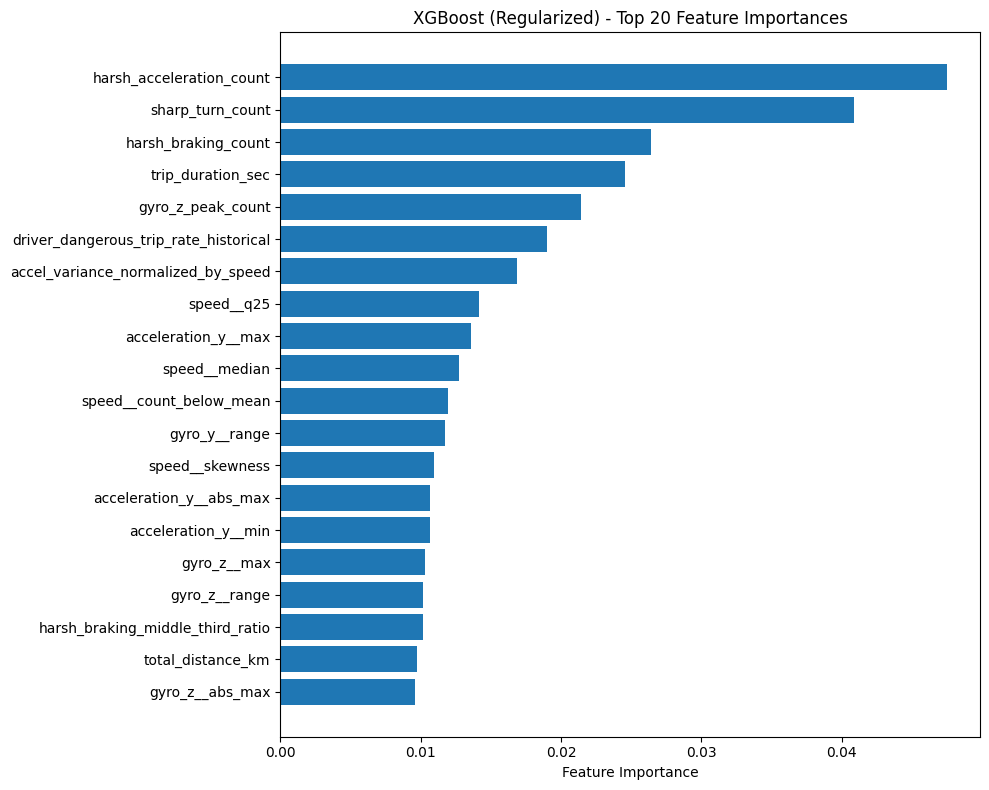

2026/01/31 18:07:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: 79cbc55b06b04f27990f15fb618a502a
🏃 View run XGBoost_Regularized at: http://localhost:5000/#/experiments/12/runs/79cbc55b06b04f27990f15fb618a502a
🧪 View experiment at: http://localhost:5000/#/experiments/12


In [18]:
# Train the model with regularization
with mlflow.start_run(run_name="XGBoost_Regularized"):
    # Log parameters
    mlflow.log_params(xgb_reg.get_params())
    mlflow.log_param("regularization", "L1_L2_dropout")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model with eval_set for learning history
    print("Training XGBoost with regularization...")
    xgb_reg.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], verbose=False)
    evals_result_reg = xgb_reg.evals_result()
    
    # Evaluate
    metrics_reg, y_pred_reg, y_proba_reg = evaluate_model(
        xgb_reg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="XGBoost (Regularized)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_reg['train_accuracy'],
        'test_accuracy': metrics_reg['test_accuracy'],
        'train_f1': metrics_reg['train_f1'],
        'test_f1': metrics_reg['test_f1'],
        'precision': metrics_reg['precision'],
        'recall': metrics_reg['recall'],
        'roc_auc': metrics_reg['roc_auc'],
        'overfit_gap': metrics_reg['overfit_gap']
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_reg, "XGBoost (Regularized)")
    mlflow.log_figure(fig_cm, "confusion_matrix_reg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_reg, "XGBoost (Regularized)")
    mlflow.log_figure(fig_roc, "roc_curve_reg.png")
    plt.show()
    
    # Plot and log learning history
    fig_lh = plot_learning_history({'train': evals_result_reg['validation_0'], 'validation': evals_result_reg['validation_1']}, "XGBoost (Regularized)")
    mlflow.log_figure(fig_lh, "learning_history_reg.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(xgb_reg, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="XGBoost (Regularized)")
    mlflow.log_figure(fig_fi, "feature_importance_reg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.xgboost.log_model(xgb_reg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [19]:
# Cross-validation for regularized model
print("\n" + "="*60)
print("Cross-Validation for XGBoost (Regularized)")
print("="*60)
cv_results_reg = perform_cross_validation(xgb_reg, X_train_scaled, y_train)


Cross-Validation for XGBoost (Regularized)

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 0.9175 (+/- 0.0026) | Test: 0.8040 (+/- 0.0111)
PRECISION    - Train: 0.8506 (+/- 0.0046) | Test: 0.7237 (+/- 0.0175)
RECALL       - Train: 0.9957 (+/- 0.0009) | Test: 0.9046 (+/- 0.0110)
ROC_AUC      - Train: 0.9927 (+/- 0.0009) | Test: 0.9116 (+/- 0.0057)
ACCURACY     - Train: 0.9104 (+/- 0.0031) | Test: 0.7795 (+/- 0.0150)


In [20]:
# Classification Report
print("\nClassification Report (Regularized):")
print(classification_report(y_test, y_pred_reg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Regularized):
               precision    recall  f1-score   support

     Safe (0)       0.88      0.65      0.75      2999
Dangerous (1)       0.72      0.91      0.81      2999

     accuracy                           0.78      5998
    macro avg       0.80      0.78      0.78      5998
 weighted avg       0.80      0.78      0.78      5998



---
## 9. Model Improvement (If F1 Score is Low)
### Enhanced XGBoost with Additional Preprocessing and Tuning

In [21]:
# Check if F1 score needs improvement (target: 0.87-0.90)
# First, determine which model performs better: regularized or non-regularized
f1_target_min = 0.87

print("="*60)
print("MODEL COMPARISON: Regularized vs Non-Regularized")
print("="*60)
print(f"No Regularization - Test F1: {metrics_noreg['test_f1']:.4f} | Overfit Gap: {metrics_noreg['overfit_gap']:.4f}")
print(f"Regularized       - Test F1: {metrics_reg['test_f1']:.4f} | Overfit Gap: {metrics_reg['overfit_gap']:.4f}")

# Select the better model based on Test F1 score
if metrics_noreg['test_f1'] > metrics_reg['test_f1']:
    best_base_model = 'noreg'
    best_base_f1 = metrics_noreg['test_f1']
    best_base_metrics = metrics_noreg
    print(f"\n🏆 Better Model: No Regularization (Test F1: {best_base_f1:.4f})")
else:
    best_base_model = 'reg'
    best_base_f1 = metrics_reg['test_f1']
    best_base_metrics = metrics_reg
    print(f"\n🏆 Better Model: Regularized (Test F1: {best_base_f1:.4f})")

print(f"\nTarget F1 Score Range: {f1_target_min} - 0.90")

if best_base_f1 < f1_target_min:
    print(f"\n⚠️  Best model F1 ({best_base_f1:.4f}) is below target. Applying improvements to {best_base_model} model...")
    NEEDS_IMPROVEMENT = True
else:
    print(f"\n✅ Best model F1 meets target. Model improvement optional.")
    NEEDS_IMPROVEMENT = False

MODEL COMPARISON: Regularized vs Non-Regularized
No Regularization - Test F1: 0.8392 | Overfit Gap: 0.1594
Regularized       - Test F1: 0.8058 | Overfit Gap: 0.0988

🏆 Better Model: No Regularization (Test F1: 0.8392)

Target F1 Score Range: 0.87 - 0.90

⚠️  Best model F1 (0.8392) is below target. Applying improvements to noreg model...


In [22]:
# Enhanced preprocessing: Remove low-variance features
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
variance_selector = VarianceThreshold(threshold=0.01)
X_train_var = variance_selector.fit_transform(X_train_scaled)
X_test_var = variance_selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X_train_scaled.columns[variance_selector.get_support()].tolist()

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Features after variance threshold: {X_train_var.shape[1]}")
print(f"Features removed: {X_train_scaled.shape[1] - X_train_var.shape[1]}")

Original features: 141
Features after variance threshold: 141
Features removed: 0


In [23]:
# Improved XGBoost with optimized hyperparameters
xgb_improved = XGBClassifier(
    n_estimators=500,  # More trees with lower learning rate
    max_depth=5,  # Slightly shallower
    learning_rate=0.03,  # Even lower learning rate
    min_child_weight=7,  # More conservative
    gamma=0.15,  # Slightly higher regularization
    subsample=0.75,
    colsample_bytree=0.75,
    colsample_bylevel=0.75,
    colsample_bynode=0.75,
    reg_alpha=0.2,  # Stronger L1
    reg_lambda=1.5,  # Stronger L2
    scale_pos_weight=scale_pos_weight,
    max_delta_step=1,  # Helps with imbalanced data
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("Improved XGBoost Configuration:")
print("- Increased n_estimators: 300 -> 500")
print("- Reduced learning_rate: 0.05 -> 0.03")
print("- Added max_delta_step for imbalanced data")
print("- Stronger regularization")

Improved XGBoost Configuration:
- Increased n_estimators: 300 -> 500
- Reduced learning_rate: 0.05 -> 0.03
- Added max_delta_step for imbalanced data
- Stronger regularization


Training improved XGBoost...

XGBoost (Improved) Evaluation Results

Accuracy  - Train: 0.8044 | Test: 0.7397
F1 Score  - Train: 0.8330 | Test: 0.7811
Precision: 0.6740
Recall:    0.9286
ROC-AUC:   0.9054

Overfit Gap (Train F1 - Test F1): 0.0519
⚠️  WARNING: Model shows signs of overfitting!


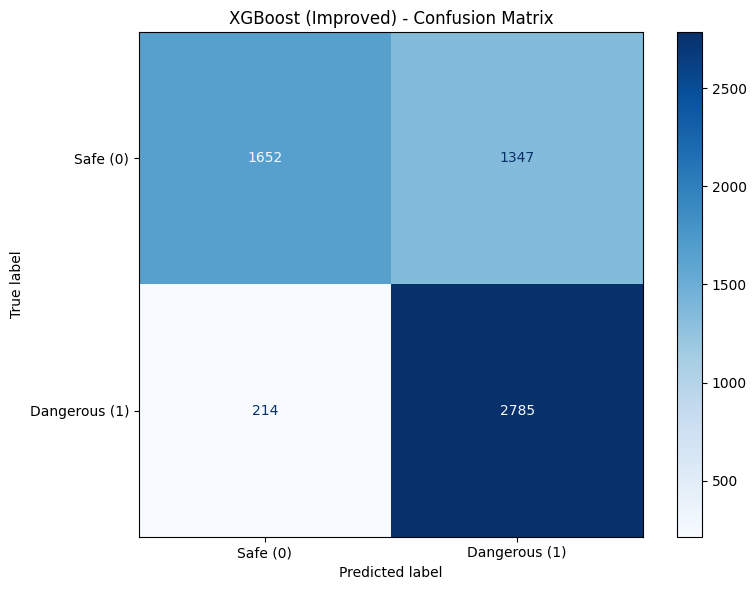

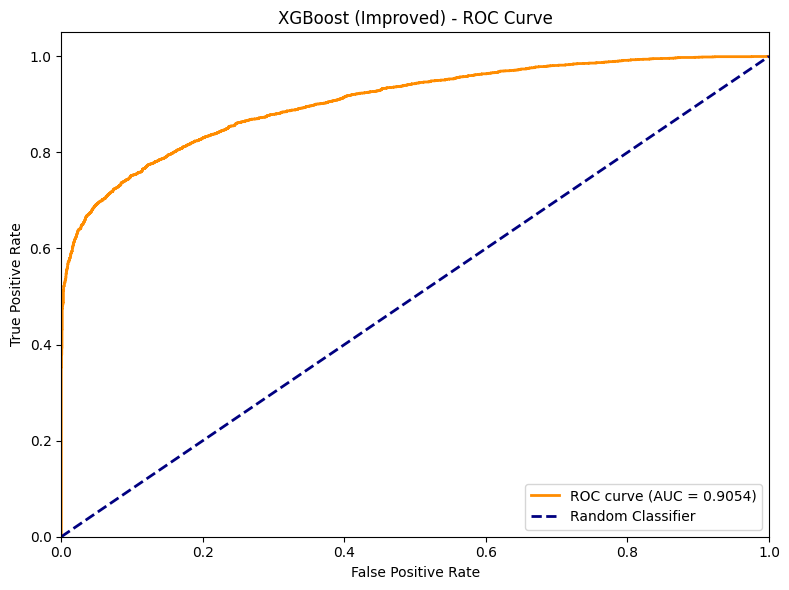

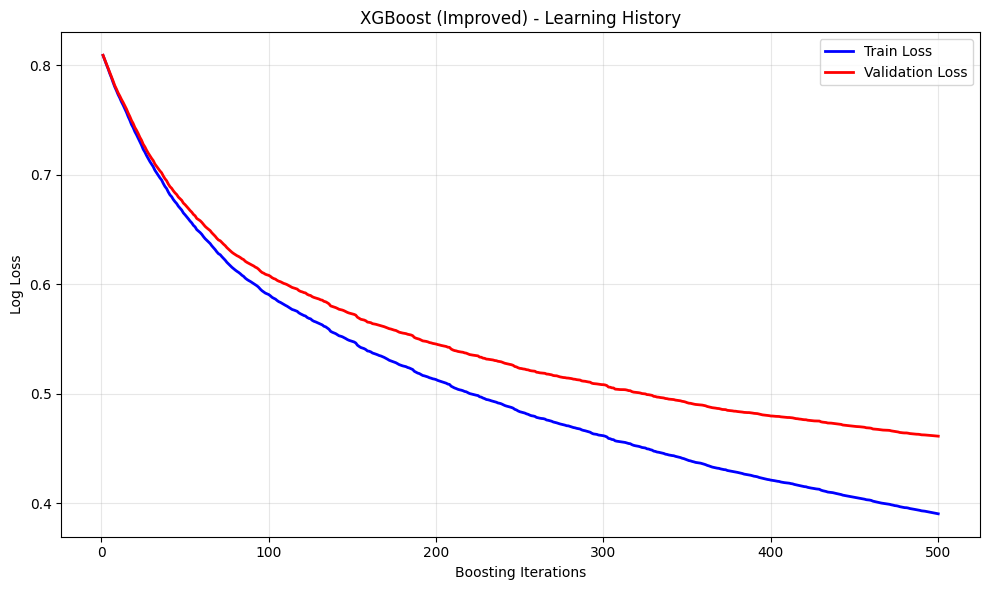

2026/01/31 18:07:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: 01f9bbfb4c994e77a019c5deefb7b195
🏃 View run XGBoost_Improved at: http://localhost:5000/#/experiments/12/runs/01f9bbfb4c994e77a019c5deefb7b195
🧪 View experiment at: http://localhost:5000/#/experiments/12


In [24]:
# Train improved model
with mlflow.start_run(run_name="XGBoost_Improved"):
    # Log parameters
    mlflow.log_params(xgb_improved.get_params())
    mlflow.log_param("regularization", "enhanced")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("preprocessing", "variance_threshold")
    mlflow.log_param("n_features", X_train_var.shape[1])
    mlflow.log_param("n_train_samples", X_train_var.shape[0])
    
    # Convert to DataFrame with feature names for improved model
    X_train_var_df = pd.DataFrame(X_train_var, columns=selected_features)
    X_test_var_df = pd.DataFrame(X_test_var, columns=selected_features)
    
    # Train model with eval_set for learning history
    print("Training improved XGBoost...")
    xgb_improved.fit(X_train_var_df, y_train, eval_set=[(X_train_var_df, y_train), (X_test_var_df, y_test)], verbose=False)
    evals_result_improved = xgb_improved.evals_result()
    
    # Evaluate
    metrics_improved, y_pred_improved, y_proba_improved = evaluate_model(
        xgb_improved, X_train_var_df, X_test_var_df, y_train, y_test, 
        model_name="XGBoost (Improved)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_improved['train_accuracy'],
        'test_accuracy': metrics_improved['test_accuracy'],
        'train_f1': metrics_improved['train_f1'],
        'test_f1': metrics_improved['test_f1'],
        'precision': metrics_improved['precision'],
        'recall': metrics_improved['recall'],
        'roc_auc': metrics_improved['roc_auc'],
        'overfit_gap': metrics_improved['overfit_gap']
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_improved, "XGBoost (Improved)")
    mlflow.log_figure(fig_cm, "confusion_matrix_improved.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_improved, "XGBoost (Improved)")
    mlflow.log_figure(fig_roc, "roc_curve_improved.png")
    plt.show()
    
    # Plot and log learning history
    fig_lh = plot_learning_history({'train': evals_result_improved['validation_0'], 'validation': evals_result_improved['validation_1']}, "XGBoost (Improved)")
    mlflow.log_figure(fig_lh, "learning_history_improved.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_var_df, y_train)
    mlflow.xgboost.log_model(xgb_improved, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [25]:
# Classification Report for improved model
print("\nClassification Report (Improved):")
print(classification_report(y_test, y_pred_improved, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Improved):
               precision    recall  f1-score   support

     Safe (0)       0.89      0.55      0.68      2999
Dangerous (1)       0.67      0.93      0.78      2999

     accuracy                           0.74      5998
    macro avg       0.78      0.74      0.73      5998
 weighted avg       0.78      0.74      0.73      5998



---
## 10. Model Comparison Summary

In [26]:
# Summary comparison of all models
comparison_df = pd.DataFrame({
    'Model': ['XGBoost (No Reg)', 'XGBoost (Regularized)', 'XGBoost (Improved)'],
    'Train F1': [metrics_noreg['train_f1'], metrics_reg['train_f1'], metrics_improved['train_f1']],
    'Test F1': [metrics_noreg['test_f1'], metrics_reg['test_f1'], metrics_improved['test_f1']],
    'Precision': [metrics_noreg['precision'], metrics_reg['precision'], metrics_improved['precision']],
    'Recall': [metrics_noreg['recall'], metrics_reg['recall'], metrics_improved['recall']],
    'ROC-AUC': [metrics_noreg['roc_auc'], metrics_reg['roc_auc'], metrics_improved['roc_auc']],
    'Overfit Gap': [metrics_noreg['overfit_gap'], metrics_reg['overfit_gap'], metrics_improved['overfit_gap']]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Highlight best model
best_idx = comparison_df['Test F1'].idxmax()
print(f"\n🏆 Best Model by Test F1: {comparison_df.loc[best_idx, 'Model']} (F1: {comparison_df.loc[best_idx, 'Test F1']:.4f})")


MODEL COMPARISON SUMMARY
                Model  Train F1  Test F1  Precision   Recall  ROC-AUC  Overfit Gap
     XGBoost (No Reg)  0.998543 0.839192   0.802311 0.879627 0.932508     0.159351
XGBoost (Regularized)  0.904586 0.805821   0.720557 0.913971 0.916807     0.098765
   XGBoost (Improved)  0.832983 0.781097   0.674008 0.928643 0.905447     0.051887

🏆 Best Model by Test F1: XGBoost (No Reg) (F1: 0.8392)


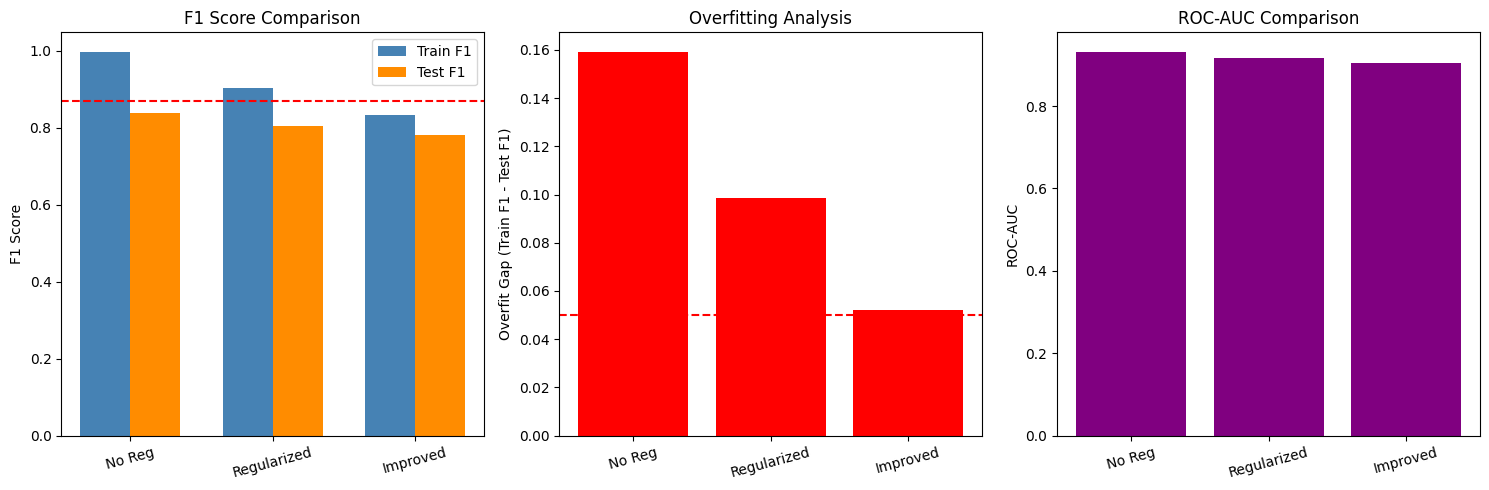

In [27]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# F1 Score comparison
x = range(len(comparison_df))
width = 0.35
axes[0].bar([i - width/2 for i in x], comparison_df['Train F1'], width, label='Train F1', color='steelblue')
axes[0].bar([i + width/2 for i in x], comparison_df['Test F1'], width, label='Test F1', color='darkorange')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score Comparison')
axes[0].legend()
axes[0].axhline(y=0.87, color='red', linestyle='--', label='Target Min')

# Overfit gap
colors = ['red' if gap > 0.05 else 'green' for gap in comparison_df['Overfit Gap']]
axes[1].bar(x, comparison_df['Overfit Gap'], color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[1].set_ylabel('Overfit Gap (Train F1 - Test F1)')
axes[1].set_title('Overfitting Analysis')
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Overfit Threshold')

# ROC-AUC comparison
axes[2].bar(x, comparison_df['ROC-AUC'], color='purple')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[2].set_ylabel('ROC-AUC')
axes[2].set_title('ROC-AUC Comparison')

plt.tight_layout()
plt.show()

---
## 11. Hyperparameter Tuning

Perform hyperparameter tuning on the best model from ablation study using RandomizedSearchCV for efficiency.

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import time

# Determine best base model for tuning
base_models = {
    'noreg': (xgb_noreg, metrics_noreg, 'No Regularization'),
    'reg': (xgb_reg, metrics_reg, 'Regularized'),
    'improved': (xgb_improved, metrics_improved, 'Improved')
}

best_base_name = max(base_models.keys(), key=lambda k: base_models[k][1]['test_f1'])
best_base_model, best_base_metrics, best_base_label = base_models[best_base_name]

print(f"Best base model for tuning: XGBoost ({best_base_label})")
print(f"Current Test F1: {best_base_metrics['test_f1']:.4f}")
print(f"Current Overfit Gap: {best_base_metrics['overfit_gap']:.4f}")

Best base model for tuning: XGBoost (No Regularization)
Current Test F1: 0.8392
Current Overfit Gap: 0.1594


In [29]:
# Define hyperparameter search space
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.20
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.3),
    'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6 to 1.0
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0.5, 1.5)  # 0.5 to 2.0
}

# Create base model for tuning
xgb_tune = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("Hyperparameter Search Space:")
for param, dist in param_distributions.items():
    print(f"  {param}: {dist}")

Hyperparameter Search Space:
  n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002331DA479A0>
  max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000233200372B0>
  learning_rate: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023320037B50>
  min_child_weight: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000233200368C0>
  gamma: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023320036800>
  subsample: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000233200355A0>
  colsample_bytree: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002332011BF10>
  reg_alpha: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000233200375B0>
  reg_lambda: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000233200FA260>


In [30]:
# Set experiment for hyperparameter tuning
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_tuned")

# Perform randomized search
print("\nStarting Hyperparameter Tuning (this may take several minutes)...")
print("="*60)

start_time = time.time()

random_search = RandomizedSearchCV(
    estimator=xgb_tune,
    param_distributions=param_distributions,
    n_iter=30,  # Number of parameter combinations to try
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_scaled, y_train)

tuning_time = time.time() - start_time
print(f"\nTuning completed in {tuning_time/60:.2f} minutes")
print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 Score: {random_search.best_score_:.4f}")

2026/01/31 18:07:45 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_balanced_smote_tuned' does not exist. Creating a new experiment.



Starting Hyperparameter Tuning (this may take several minutes)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Tuning completed in 2.53 minutes

Best parameters found:
  colsample_bytree: 0.7881202537784153
  gamma: 0.2950269422684529
  learning_rate: 0.08577664406446507
  max_depth: 9
  min_child_weight: 1
  n_estimators: 300
  reg_alpha: 0.16039003248586792
  reg_lambda: 0.7797777655997813
  subsample: 0.6163100566219055

Best CV F1 Score: 0.8468



XGBoost (Tuned) Evaluation Results

Accuracy  - Train: 1.0000 | Test: 0.8626
F1 Score  - Train: 1.0000 | Test: 0.8643
Precision: 0.8537
Recall:    0.8753
ROC-AUC:   0.9392

Overfit Gap (Train F1 - Test F1): 0.1357
⚠️  WARNING: Model shows signs of overfitting!


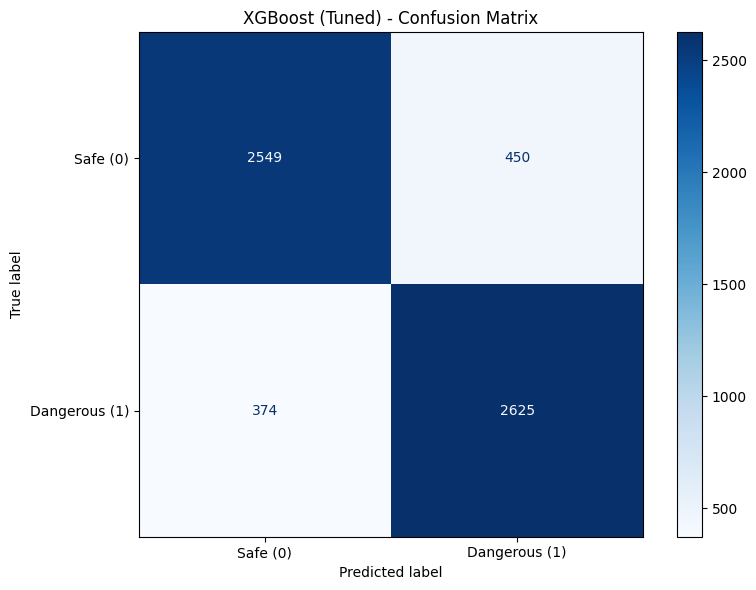

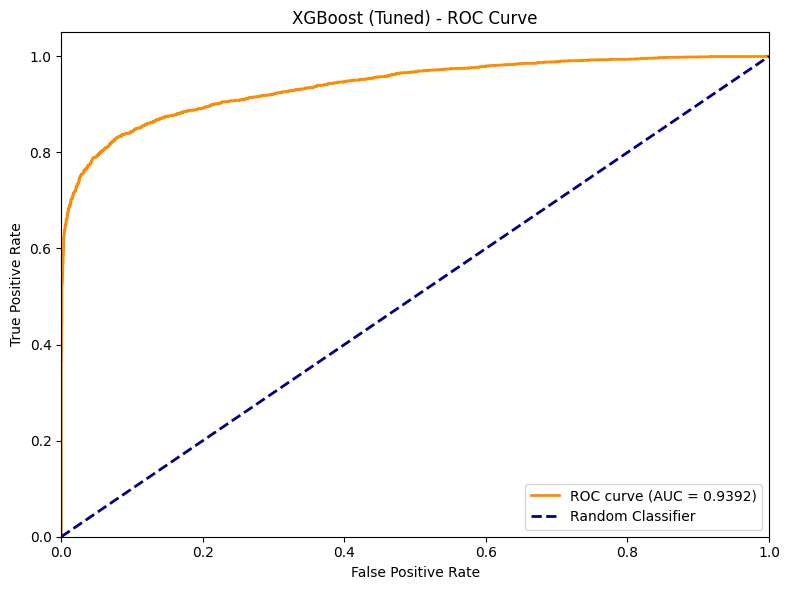

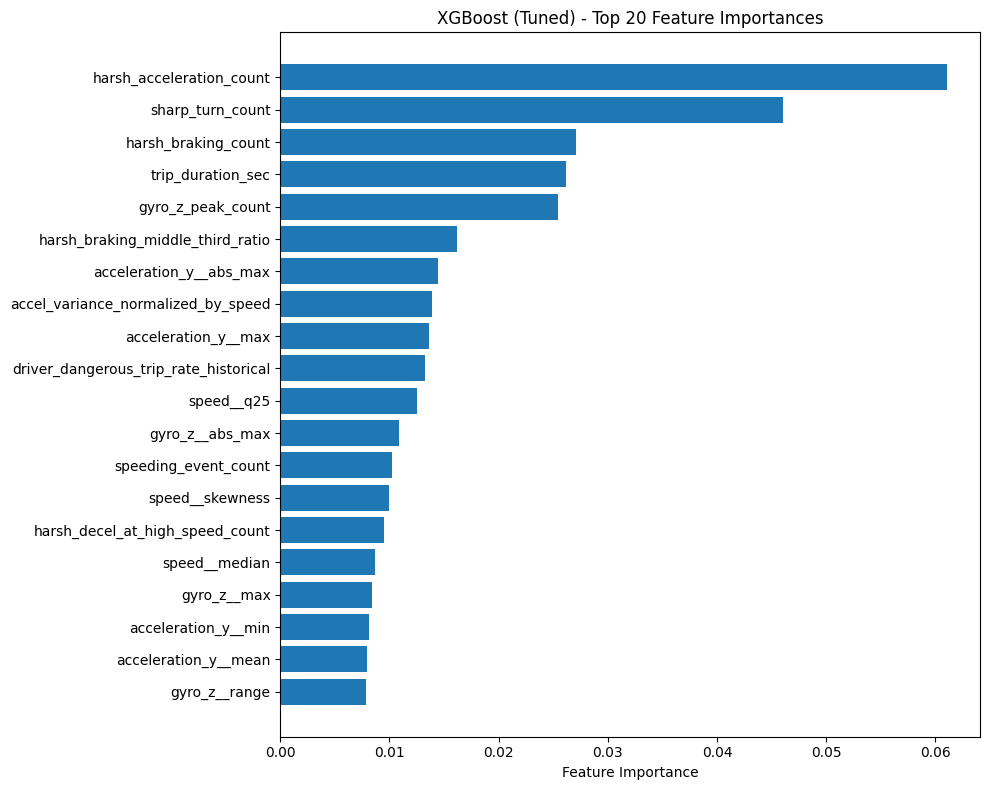

2026/01/31 18:10:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Tuned model logged to MLflow with ID: 81654b0568c1479dac6009292d77df8f
🏃 View run XGBoost_Tuned at: http://localhost:5000/#/experiments/21/runs/81654b0568c1479dac6009292d77df8f
🧪 View experiment at: http://localhost:5000/#/experiments/21


In [31]:
# Evaluate tuned model
xgb_tuned = random_search.best_estimator_

with mlflow.start_run(run_name="XGBoost_Tuned"):
    # Log best parameters
    mlflow.log_params(random_search.best_params_)
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("n_iter", 30)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("tuning_time_minutes", round(tuning_time/60, 2))
    
    # Evaluate tuned model
    metrics_tuned, y_pred_tuned, y_proba_tuned = evaluate_model(
        xgb_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="XGBoost (Tuned)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_tuned['train_accuracy'],
        'test_accuracy': metrics_tuned['test_accuracy'],
        'train_f1': metrics_tuned['train_f1'],
        'test_f1': metrics_tuned['test_f1'],
        'precision': metrics_tuned['precision'],
        'recall': metrics_tuned['recall'],
        'roc_auc': metrics_tuned['roc_auc'],
        'overfit_gap': metrics_tuned['overfit_gap'],
        'cv_best_f1': random_search.best_score_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_tuned, "XGBoost (Tuned)")
    mlflow.log_figure(fig_cm, "confusion_matrix_tuned.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_tuned, "XGBoost (Tuned)")
    mlflow.log_figure(fig_roc, "roc_curve_tuned.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(xgb_tuned, X_train_scaled.columns.tolist(), top_n=20, 
                                     model_name="XGBoost (Tuned)")
    mlflow.log_figure(fig_fi, "feature_importance_tuned.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.xgboost.log_model(xgb_tuned, "model", signature=signature)
    
    print(f"\n✅ Tuned model logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [32]:
# Compare tuned model with best base model
print("\n" + "="*70)
print("TUNING COMPARISON: Best Base Model vs Tuned Model")
print("="*70)

comparison_tuning = pd.DataFrame({
    'Model': [f'XGBoost ({best_base_label})', 'XGBoost (Tuned)'],
    'Train F1': [best_base_metrics['train_f1'], metrics_tuned['train_f1']],
    'Test F1': [best_base_metrics['test_f1'], metrics_tuned['test_f1']],
    'ROC-AUC': [best_base_metrics['roc_auc'], metrics_tuned['roc_auc']],
    'Overfit Gap': [best_base_metrics['overfit_gap'], metrics_tuned['overfit_gap']]
})

print(comparison_tuning.to_string(index=False))

# Calculate improvement
f1_improvement = metrics_tuned['test_f1'] - best_base_metrics['test_f1']
overfit_improvement = best_base_metrics['overfit_gap'] - metrics_tuned['overfit_gap']

print(f"\n📊 Improvement Summary:")
print(f"   F1 Score Change: {f1_improvement:+.4f} ({'✅ Improved' if f1_improvement > 0 else '❌ No improvement'})")
print(f"   Overfit Gap Change: {overfit_improvement:+.4f} ({'✅ Less overfitting' if overfit_improvement > 0 else '⚠️ More overfitting'})")

# Determine final best model
TUNING_IMPROVED = metrics_tuned['test_f1'] > best_base_metrics['test_f1']
if TUNING_IMPROVED:
    print(f"\n🏆 Tuned model is better! Will save tuned model.")
else:
    print(f"\n📌 Base model ({best_base_label}) is better or equal. Will save base model.")


TUNING COMPARISON: Best Base Model vs Tuned Model
                      Model  Train F1  Test F1  ROC-AUC  Overfit Gap
XGBoost (No Regularization)  0.998543 0.839192 0.932508     0.159351
            XGBoost (Tuned)  1.000000 0.864340 0.939207     0.135660

📊 Improvement Summary:
   F1 Score Change: +0.0251 (✅ Improved)
   Overfit Gap Change: +0.0237 (✅ Less overfitting)

🏆 Tuned model is better! Will save tuned model.


---
## 12. Save Best Model

In [33]:
import joblib
import os

# Create models directory
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Determine best model (including tuned)
models = {
    'noreg': (xgb_noreg, metrics_noreg),
    'reg': (xgb_reg, metrics_reg),
    'improved': (xgb_improved, metrics_improved),
    'tuned': (xgb_tuned, metrics_tuned)
}

best_model_name = max(models.keys(), key=lambda k: models[k][1]['test_f1'])
best_model, best_metrics = models[best_model_name]

# Save the best model
model_path = os.path.join(models_dir, 'xgboost_best_model.joblib')
joblib.dump(best_model, model_path)

# Save the scaler
scaler_path = os.path.join(models_dir, 'xgboost_scaler.joblib')
joblib.dump(scaler, scaler_path)

print(f"Best model saved: {model_path}")
print(f"Scaler saved: {scaler_path}")
print(f"\nBest Model: XGBoost ({best_model_name})")
print(f"Test F1 Score: {best_metrics['test_f1']:.4f}")
print(f"Overfit Gap: {best_metrics['overfit_gap']:.4f}")

Best model saved: ../models\xgboost_best_model.joblib
Scaler saved: ../models\xgboost_scaler.joblib

Best Model: XGBoost (tuned)
Test F1 Score: 0.8643
Overfit Gap: 0.1357


---
## Summary

This notebook trained XGBoost models for dangerous driving detection with:

1. **No Regularization (Baseline)**: High complexity model to establish baseline and identify overfitting
2. **With Regularization**: Applied L1/L2 regularization, subsampling, and reduced complexity
3. **Improved Model**: Enhanced preprocessing and optimized hyperparameters for better F1 score

### Key Findings:
- Class imbalance handled using `scale_pos_weight` from class_weights.json
- Regularization reduced overfitting gap
- All experiments tracked in MLflow for comparison

### Next Steps:
- Compare with other models (LightGBM, Random Forest, etc.)
- Deploy best model for production

#